# ANNa

**ANNa** is  a **Convolutional Network for Biomedical Image Segmentation** (**U-Net**).

Essentially, it is a deep-learning framework based on **fully convolutional neural** (**FCNs**) networks.

It's pixel-accuracy results are because the model classifies each pixel individually.

## 0. Import libraries

### Standard Libraries

In [ ]:
# STANDARD LIBRARIES
# System and file management
import sys
import os
from tqdm import tqdm
# import shutil # functions of high-level operations on files and collections of files
import glob  # functions to organize files under a specified folder

# Drive
from google.colab import drive
from google.colab import files

# Images
import cv2 # opencv-free library for artificial vision
import PIL # python imaging library
from PIL import Image 

# Pandas and Numpy
import pandas as pd
import numpy as np
from numpy import savetxt
import random
import regex as re

# Visualization tools
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

In [ ]:
# TensorFlow
import tensorflow as tf

# Keras
from keras.models import Model, load_model

from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout, Flatten
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras import backend as K
from keras.callbacks import  Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from keras.optimizers import Adam, SGD

In [ ]:
tf.test.gpu_device_name()

''

In [ ]:
# ! pip freeze

In [ ]:
# Scikit-learn
# from sklearn.utils import shuffle

# Engineering
from sklearn.model_selection import learning_curve

# Metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,f1_score, precision_score, recall_score
from sklearn.model_selection import validation_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

### Activate Drive

In [ ]:
# Mount google drive in google colab
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Custom libraries (Python)

In [ ]:
sys.path.insert(0,'/content/drive/My Drive/IRONHACK/PROJECTS/CNN-Leukemia/notebooks/modules')

In [ ]:
# Availables python functions 
!ls '/content/drive/My Drive/IRONHACK/PROJECTS/CNN-Leukemia/notebooks/modules'

classification.py    image_viz.py	     __pycache__
eda.py		     old		     test.py
files_management.py  performance_checker.py  unet.py


In [ ]:
# CUSTOM LIBRARIES

# File management
import files_management as fm

# Vizualizations
import image_viz as iv
import eda

# U-Net
import unet
# Classification
import classification as cls

# Performance Charts
import performance_checker as pc

## 1.Paths

### General

In [ ]:
# Drive paths
GEN_DRIVE = '/content/drive'
DRIVE = '/My Drive' 
PROJECT = '/IRONHACK/PROJECTS/CNN-Leukemia'
  
# Folder containing the original data.
INPUT = '/input'

# Folder containing the notebooks.
NB = '/notebooks'
# Functions
FUNCTION = GEN_DRIVE+DRIVE+PROJECT+NB+'/modules'  

# Folder containing the outputs (arrays/csv/viz/models).
OUTPUT = '/output/'
SUBFOLDER = ['arrays/','models/','viz/']
# Arrays
DEST = ['128x128','450x450','validation']

# Training images
# Images are stored in three different folders (fold_0, fold_1, fold_2)
TRAIN = '/training_data/'
FOLDERS = ['fold_0','fold_1','fold_2']
# Diseasedd Cells (ALL)/ Non-Diseased Cells (HEM)
CELLS = ['all', 'hem']

# Valudation data
VALIDATION = '/validation_data/C-NMC_test_prelim_phase_data'

In [ ]:
# General Paths
# INPUT folder
path_input = GEN_DRIVE+DRIVE+PROJECT+INPUT
# Training Data
train_path = path_input+TRAIN

# Validation
path_val = path_input+VALIDATION

# Arrays
arrays_path = GEN_DRIVE+DRIVE+PROJECT+OUTPUT+'arrays/'

### Input


![picture](https://drive.google.com/uc?id=1XIhgCHritHcTbR1gCIsUReAXo3S0hkOz)

In [ ]:
# Export Data

# Arrays
arrays_path = GEN_DRIVE+DRIVE+PROJECT+OUTPUT+SUBFOLDER[0]
# Models
path_model = GEN_DRIVE+DRIVE+PROJECT+OUTPUT+SUBFOLDER[1]
path_cp = GEN_DRIVE+DRIVE+PROJECT+OUTPUT+SUBFOLDER[1]+'checkpoints/'
# Viz
path_viz = GEN_DRIVE+DRIVE+PROJECT+OUTPUT+SUBFOLDER[2]+'/'

## 2.Load Data

### 2.1 Training Data

Let's load the module: **files_management** as **fm**

Labelling data:

  - **ALL** (Leukemia cells): **1**
  - **HEM** (Healty cells): **0**

In [ ]:
# Training Set
# Images
images=['fold_0_all_images','fold_0_hem_images','fold_1_all_images','fold_1_hem_images','fold_2_all_images','fold_2_hem_images']
#Labels
labels=['fold_0_all_labels','fold_0_hem_labels','fold_1_all_labels','fold_1_hem_labels','fold_2_all_labels','fold_2_hem_labels']

In [ ]:
training_data = []

for i,l in zip(images,labels):
  # print(i,l)
  training_data.append(fm.load_data(arrays_path+DEST[0]+'/', i, l, '.npy'))

In [ ]:
X_train=[]
y_train=[]

for ind, (i,l) in enumerate(zip(images,labels)):
  # print(ind)

  training_data=fm.load_data(arrays_path+DEST[0]+'/', i, l, '.npy')

  X_train.extend(training_data[0])
  y_train.extend(training_data[1])

X_train=np.array(X_train)
y_train=np.array(y_train)

In [ ]:
print(f'Training Set: {y_train.shape[0]} images')

Training Set: 10661 images


### 2.2 Validation Data

We resize the Validation set in order to make predictions (we only use 20% of the images of the Validation Set).

In [ ]:
# print(f'Reduced Validation Set: {round(y_train.shape[0]*0.2)} images')

In [ ]:
# Validation Data
val_128_images='val_128_images'

In [ ]:
# Images
val = fm.load_data(arrays_path+DEST[2]+'/', val_128_images, 0,'.npy')

In [ ]:
X_val = val

In [ ]:
# DF with labels
validation_df = pd.read_csv(path_val+'_labels.csv')
validation_df.head(2)

,Patient_ID,new_names,labels
0,UID_57_29_1_all.bmp,1.bmp,1
1,UID_57_22_2_all.bmp,2.bmp,1


In [ ]:
y_val = (validation_df.labels).to_numpy()

In [ ]:
y_val.shape

(1867,)

## 3.ANNa

#### Library

The model will be implemented with **Keras**, a high-level API that sits on top of other Deep Learning frameworks. Currently it supports TensorFlow, Theano, and CNTK.

With the Functional API, neural networks are defined as a set of sequential functions, applied one after the other.

Let's load the module: **unet** (If you are curious about the Network structure, please explore: `unet.py`.)

### Structure

For detailed information about U-Net structure, please check out this article: [U-Net line by line explanation](https://towardsdatascience.com/unet-line-by-line-explanation-9b191c76baf5)

In general, most **U-Net** follows the same structure.

<p align="center", >
  <img width="518" height="345" src="https://drive.google.com/uc?id=1JH3ANoD-A0-fgu0i-uwzImWa3JbjxBIX">  
</p>

#### Contracting Path

`conv_layer1 -> conv_layer2 -> max_pooling -> dropout(optional)` (4 times)

<p align="center", >
  <img width="172" height="276" src="https://drive.google.com/uc?id=1optTelkK90Cv1szXkjR7sPzut348Y66w">  
</p>

**Convolutional Central Layers**

`conv_2d_transpose -> concatenate -> conv_layer1 -> conv_layer2`

<p align="center", >
  <img width="172" height="41" src="https://drive.google.com/uc?id=1w7aMmuk6C4rpXWDTD8oFHzFyGb4A-o-z">  
</p>

<p align="center", >
    
</p>

#### Expansive Path

`conv_2d_transpose -> concatenate -> conv_layer1 -> conv_layer2` (4 times)

<p align="center", >
  <img width="172" height="240" src="https://drive.google.com/uc?id=1Z8h-s8iz14RrFLXYTcY2BhEku5KujQR-">  
</p>

### U-Net

Let's load the module: **unet** (If you are curious about the Network structure, please explore: `unet.py`.)

In [ ]:
# Variables
dim=X_train.shape
n_filters = 4

In [ ]:
input_layer = Input((dim[1],dim[2],3))

In [ ]:
# U-Net Model
# - Input: image shape
# - Output: unet_output
unet_output=unet.model(input_layer, n_filters)

### Classification

In [ ]:
# Classification Model
# - Input: unet_output
# - Output: classification_output
classification_output = cls.classification_model_2(unet_output)

In [ ]:
# ANNa
# - Input: input_layer
# - Output: classification_output
model = Model(input_layer, classification_output)

### Summary

In [ ]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 4)  112         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 4)  148         conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 4)    0           conv2d_1[0][0]                   
_______________________________________________________________________________________

## 4. Compilation and Training

### Variables

In [ ]:
# Variables
epochs = 20

# Max batch size= available GPU memory bytes / 4 / (size of tensors + trainable parameters)
batch =32

### 4.1 Compilation

#### Custom metrics

The f1 score is the weighted average of precision and recall. So to calculate f1 we need to create functions that calculate precision and recall first. 

In [ ]:
f1=unet.get_f1

In [ ]:
loss = 'binary_crossentropy'
opt = ['Adam', SGD(lr=0.001, momentum=0.9, decay=0.01)] # Adam/Stochastic Gradient Descent
metric = ['acc',f1,'AUC'] # AUC tells how much model is capable of distinguishing between classes.

In [ ]:
model.compile(loss=loss, optimizer=opt[0], metrics=metric)

### Callbacks

#### Early Stopping

**Early Stopping** is a regularization technique to combat the **overfitting** issue. With Early Stopping, we just stop training as soon as the validation error reaches the minimum.

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=round(0.1*epochs), # There is a rule of thumb to make it 10% of number of epoch.
                               verbose=1) 

#### Model Checkpoint

In [ ]:
# ModelCheckpoint Callback
model_checkpoint = ModelCheckpoint(path_cp+'ANNa_Model.h5',
                                   monitor='loss', 
                                   save_best_only=True, 
                                   save_weights_only=True,
                                   verbose=0)

#### Learning Rate

In [ ]:
# Reduce learning rate when a metric has stopped improving.
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.1, 
                              patience=3, 
                              min_lr=0.0001, 
                              verbose=1)

In [ ]:
# Callbacks
callbacks=[early_stopping, model_checkpoint, reduce_lr]

### 4.2 Training

In [ ]:
# Reduced DataSet
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val), 
                    epochs=epochs,
                    verbose = 1,
                    batch_size=batch,                  
                    callbacks=callbacks,
                    shuffle=True)

Epoch 1/20
334/334 [==============================] - 525s 2s/step - loss: 0.5921 - acc: 0.7102 - get_f1: 0.8064 - auc: 0.6735 - val_loss: 0.6722 - val_acc: 0.6304 - val_get_f1: 0.7648 - val_auc: 0.4934
Epoch 2/20
334/334 [==============================] - 522s 2s/step - loss: 0.4722 - acc: 0.7964 - get_f1: 0.8564 - auc: 0.8152 - val_loss: 0.7740 - val_acc: 0.6358 - val_get_f1: 0.7704 - val_auc: 0.4944
Epoch 3/20
334/334 [==============================] - 520s 2s/step - loss: 0.4553 - acc: 0.8036 - get_f1: 0.8604 - auc: 0.8282 - val_loss: 0.7772 - val_acc: 0.5972 - val_get_f1: 0.7211 - val_auc: 0.4924
Epoch 00003: early stopping


In [ ]:
# Save Model
model.save(path_model+'ANNa01_Model.h5')

In [ ]:
# y_train=pd.Series(y_train)
# y_train.value_counts()/len(y_train)

In [ ]:
# y_val=pd.Series(y_val)
# type(y_val)
# y_val.value_counts()/len(y_val)

## 5. Evaluation

In [ ]:
# Model Evaluation
# tr_score = model.evaluate(X_train, y_train, batch_size=batch, verbose=1) 

In [ ]:
# print('Train Loss:', str(round(tr_score[0]*100,2))+'%') 
# print('Train Accuracy:', str(round(tr_score[1]*100,2))+'%')
# print('Train f1_score:', str(round(tr_score[2]*100,2))+'%')

In [ ]:
# Model Evaluation
# val_score = model.evaluate(X_val, y_val, batch_size=batch, verbose=1) 

In [ ]:
# print('Val Loss:', str(round(val_score[0]*100,2))+'%') 
# print('Val Accuracy:', str(round(val_score[1]*100,2))+'%')
# print('Val f1_score:', str(round(val_score[2]*100,2))+'%')

We generate the performance data of the different epochs.

In [ ]:
# epochs_es = 

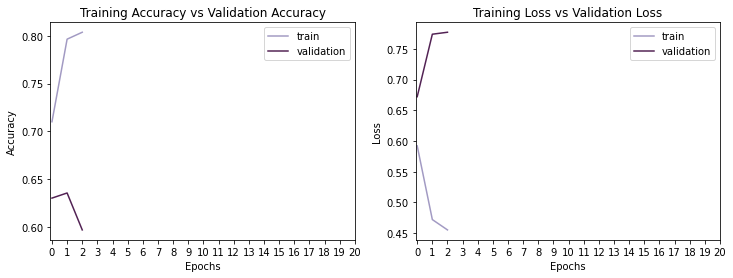

In [ ]:
# Accuracy and Loss behavior over epochs
pc.plot_metric(history,epochs,epochs,'#a29ac3','#522254',12,4,1)

From the above graph, we can see that the model has overfitted the training data, so it outperforms the validation set.

In [ ]:
plt.savefig(path_viz+'ANNa_graphs.jpg')

<Figure size 864x288 with 0 Axes>